##  Importing the libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV


### Loading the dataset

In [2]:
data = pd.read_csv("E:\\learnings great\\car-mpg.csv")

### Now go through the data or perform some EDA (Exploratory Data Analysis), to understand and get familiar with the dataset.

#### Viewing first five rows of data

In [3]:
data.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,car_type,car_name
0,18.0,8,307.0,130,3504,12.0,70,1,0,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,0,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,0,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,0,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,0,ford torino


In [4]:

data.loc[data['hp']=='?'].head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,car_type,car_name
32,25.0,4,98.0,?,2046,19.0,71,1,1,ford pinto
126,21.0,6,200.0,?,2875,17.0,74,1,0,ford maverick
330,40.9,4,85.0,?,1835,17.3,80,2,1,renault lecar deluxe
336,23.6,4,140.0,?,2905,14.3,80,1,1,ford mustang cobra
354,34.5,4,100.0,?,2320,15.8,81,2,1,renault 18i


In [5]:
data = data.drop(['car_name'], axis = 1)

In [6]:
# we can see that the odd value is '?' representing null
# so we now change it to NaN value and fill the spot with the median hp(horsepower)
data.hp = data.hp.str.replace('?','NaN').astype(float)
data.hp.fillna(data.hp.median(),inplace=True)
data.hp = data.hp.astype(int)



In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mpg       398 non-null    float64
 1   cyl       398 non-null    int64  
 2   disp      398 non-null    float64
 3   hp        398 non-null    int32  
 4   wt        398 non-null    int64  
 5   acc       398 non-null    float64
 6   yr        398 non-null    int64  
 7   origin    398 non-null    int64  
 8   car_type  398 non-null    int64  
dtypes: float64(3), int32(1), int64(5)
memory usage: 26.6 KB


In [8]:
# To show the summary statistics of numeric variables.
data.describe()

,mpg,cyl,disp,hp,wt,acc,yr,origin,car_type
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.296482,2970.424623,15.568090,76.010050,1.572864,0.530151
std,7.815984,1.701004,104.269838,38.224809,846.841774,2.757689,3.697627,0.802055,0.499718
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,0.000000
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,1.000000,0.000000
50%,23.000000,4.000000,148.500000,93.000000,2803.500000,15.500000,76.000000,1.000000,1.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000,1.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,1.000000


In [9]:
dtype_df = data.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int32,1
1,int64,5
2,float64,3


In [10]:
# Checking for Null values
data.isnull().sum()

mpg         0
cyl         0
disp        0
hp          0
wt          0
acc         0
yr          0
origin      0
car_type    0
dtype: int64

In [11]:
# check for duplicates and null values
print('sum of duplicated values{}'   \
      .format(data.duplicated().sum()))
print('sum of null values: {}'.format(data.isnull().sum()))

sum of duplicated values0
sum of null values: mpg         0
cyl         0
disp        0
hp          0
wt          0
acc         0
yr          0
origin      0
car_type    0
dtype: int64


In [12]:
# Using VIF to check the presence of Multicollinearity
# If VIF < 5 then there is marginal multicollinearity between the variables.
# If VIF > 5 then serious multicollinearity between two predictor variables.
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [13]:
features = "+".join(data.columns.difference(["mpg"]))

In [14]:
features

'acc+car_type+cyl+disp+hp+origin+wt+yr'

In [15]:
a, b = dmatrices(formula_like= 'mpg ~ ' + features,data=data,return_type="dataframe")
vif = pd.DataFrame()

vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["Features"] = b.columns

In [16]:
vif

,VIF Factor,Features
0,829.667505,Intercept
1,2.555832,acc
2,6.870139,car_type
3,17.668773,cyl
4,21.902410,disp
5,9.996561,hp
6,1.777948,origin
7,10.719674,wt
8,1.248284,yr


In [17]:
# Droping the features which having strong multicollinearity
data = data.drop(['cyl','disp','wt','hp'], axis = 1)

### Let’s visualize the relationships between the Mileage Per Galon(mpg) of a car and the other features.

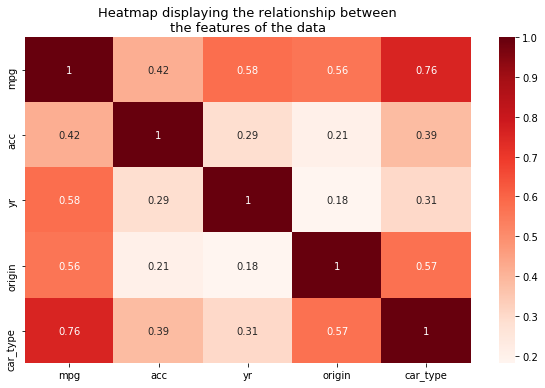

In [19]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between\nthe features of the data',fontsize=13)
plt.show()

In [20]:
data.corr()

,mpg,acc,yr,origin,car_type
mpg,1.000000,0.420289,0.579267,0.563450,0.759207
acc,0.420289,1.000000,0.288137,0.205873,0.385187
yr,0.579267,0.288137,1.000000,0.180662,0.305194
origin,0.563450,0.205873,0.180662,1.000000,0.572691
car_type,0.759207,0.385187,0.305194,0.572691,1.000000


** There is a strong negative correlation between the displacement,horsepower,weight,and cylinders.This implies that,as any one of those variables increases,the mpg decreases.
** The displacement,horsepower,weight,and cylinders have a strong positive correlations between themselves and this violates the non-multi collinearity assumption of Linear regression

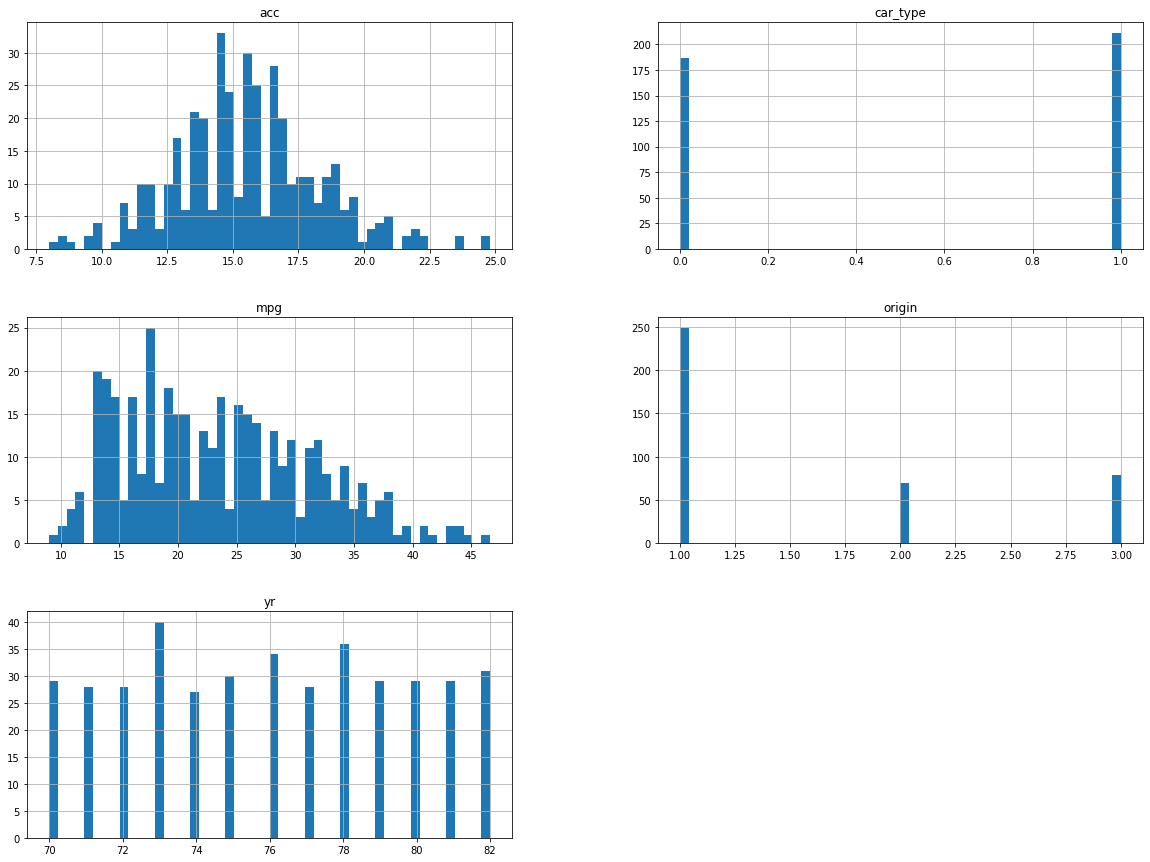

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))

plt.savefig("attribute_histogram_plots")
plt.show()

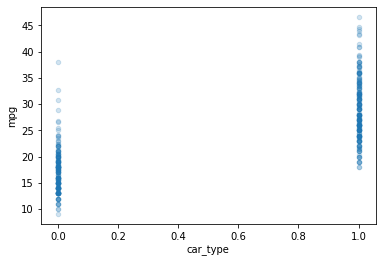

In [22]:
data.plot(kind="scatter", x="car_type", y="mpg", alpha=0.2)
plt.savefig('map1.png')

In [23]:
corr_matrix = data.corr()
corr_matrix["mpg"].sort_values(ascending=False)

mpg         1.000000
car_type    0.759207
yr          0.579267
origin      0.563450
acc         0.420289
Name: mpg, dtype: float64

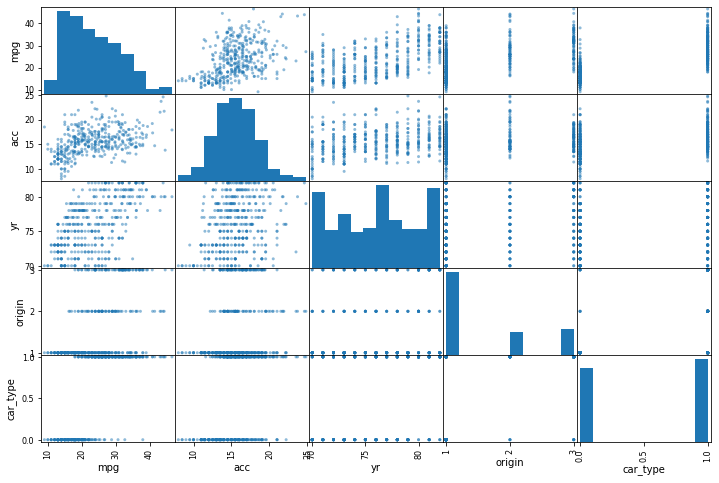

In [25]:
from pandas.plotting import scatter_matrix
attributes = ['mpg', 'acc', 'yr', 'origin', 'car_type']
scatter_matrix(data[attributes], figsize=(12, 8))
plt.savefig("scatter_matrix_plot.png")
plt.show()

In [26]:
data_dup = data.duplicated()
sum(data_dup)

12

### Converting dataset to dependent and independant vectors

In [27]:
X = data.drop(['mpg'], axis = 1)
y = data['mpg']

In [28]:
# Splitting the dataset into testing and training set's
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [29]:
# Dimensions of datset after splitting into testing and training set's

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(298, 4)
(100, 4)
(298,)
(100,)


In [34]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(X_train)
X_train_res=scaler.transform(X_train)
X_test_res=scaler.transform(X_test)
print(X_train_res)
print(X_test_res)

[[-0.45458866  0.53837478 -0.71698901  0.95407359]
 [ 0.30443371 -0.86158757  1.78199023  0.95407359]
 [-0.05700552 -1.70156498 -0.71698901 -1.04813718]
 ...
 [-0.31001297  0.53837478  1.78199023  0.95407359]
 [ 0.59358509  1.3783522   1.78199023  0.95407359]
 [ 1.93091021 -0.86158757  0.53250061  0.95407359]]
[[ 0.62972901 -0.02161016  1.78199023  0.95407359]
 [ 1.06345608  1.65834467 -0.71698901  0.95407359]
 [-0.96060357 -1.42157251 -0.71698901 -1.04813718]
 [-0.88831573 -0.02161016 -0.71698901 -1.04813718]
 [-0.41844474 -0.86158757 -0.71698901 -1.04813718]
 [ 0.30443371 -1.14158004  1.78199023  0.95407359]
 [ 0.26828979  1.65834467 -0.71698901  0.95407359]
 [-1.68348202 -0.86158757 -0.71698901 -1.04813718]
 [ 1.20803176  0.25838231 -0.71698901 -1.04813718]
 [ 0.48515332 -0.5815951  -0.71698901 -1.04813718]
 [-2.58708008 -1.70156498 -0.71698901 -1.04813718]
 [-0.23772513  1.65834467  1.78199023  0.95407359]
 [ 1.7501906  -1.42157251 -0.71698901  0.95407359]
 [-1.14132318 -1.14158004

## Building a Linear Regression Model

In [35]:
# Fitting Simple Linear Regression model to the training data
from sklearn.linear_model import LinearRegression
# Instantiating LinearRegression Model
linear_regression = LinearRegression()
# Fitting to the training data
linear_regression.fit(X_train_res, y_train)

print('Estimated intercept coefficient:', linear_regression.intercept_)

print('Number of coefficients:', linear_regression.coef_)

Estimated intercept coefficient: 23.52684563758389
Number of coefficients: [0.56353975 2.80547014 1.55191192 4.00260102]


In [36]:
predictions = linear_regression.predict(X_test_res)
linear_regression.score(X_test_res, y_test)

0.7626454406145371

In [37]:
#import libraries
from sklearn.metrics import mean_squared_error,r2_score
# model evaluation for training set
y_train_predict = linear_regression.predict(X_train_res)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)
print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")
# model evaluation for testing set
y_test_predict = linear_regression.predict(X_test_res)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
r2 = r2_score(y_test, y_test_predict)
print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 4.0945853857326835
R2 score is 0.7310140294066281


The model performance for testing set
--------------------------------------
RMSE is 3.6712159321589057
R2 score is 0.7626454406145371


In [38]:
# RMSE
from sklearn.metrics import mean_squared_error
regressor_mse = mean_squared_error(predictions, y_test)


In [39]:
import math
math.sqrt(regressor_mse)

3.6712159321589057

In [40]:
import numpy as np
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(predictions, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

Linear Regression RMSE: 3.6712


In [41]:
# Mean Absolute Error
from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(predictions, y_test)
print('Linear Regression MAE: %.4f' % lin_mae)


Linear Regression MAE: 2.9912


## Residual Plot

#### we plot a residual plot to check linear regression assumptions. Residual plot is a good way to check for homoscedasticity.

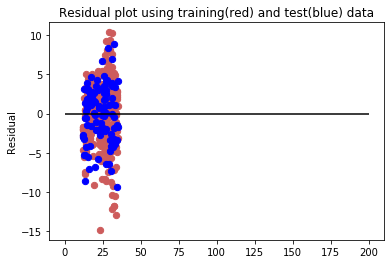

In [42]:
plt.scatter(linear_regression.predict(X_train_res), linear_regression.predict(X_train_res)-
y_train, c='indianred', s=40)
plt.scatter(linear_regression.predict(X_test_res), linear_regression.predict(X_test_res)-
y_test, c='b', s=40)
plt.hlines(y=0, xmin=0, xmax=200)
plt.title('Residual plot using training(red) and test(blue) data')
plt.ylabel('Residual')
plt.savefig('residual_plot.png')

In [43]:
model = LinearRegression()  # initialize the LinearRegression model
model.fit(X_train_res,y_train) 
linear_pred = model.predict(X_test_res)  # make prediction with the fitted model

# score the model on the train set
print('Train score: {}\n'.format(model.score(X_train_res,y_train)))
# score the model on the test set
print('Test score: {}\n'.format(model.score(X_test_res,y_test)))
# calculate the overall accuracy of the model
print('Overall model accuracy: {}\n'.format(r2_score(y_test,linear_pred)))
# compute the mean squared error of the model
print('Mean Squared Error: {}'.format(mean_squared_error(y_test,linear_pred)))

Train score: 0.7310140294066281

Test score: 0.7626454406145371

Overall model accuracy: 0.7626454406145371

Mean Squared Error: 13.477826420537385


In [46]:
ridge = Ridge(alpha=.01)
ridge.fit(X_train_res,y_train)  # fit the model with the training data

ridge_pred = ridge.predict(X_test_res)  # make predictions

# score the model to check the accuracy
print('Train score: {}\n'.format(ridge.score(X_train_res,y_train)))
print('Test score: {}\n'.format(ridge.score(X_test_res,y_test)))
print('Overall model accuracy: {}\n'.format(r2_score(y_test,ridge_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(y_test,ridge_pred)))

Train score: 0.731014029030417

Test score: 0.7626468395691675

Overall model accuracy: 0.7626468395691673

Mean Squared Error: 13.477746982974754


In [49]:
# we now try to tune the parameters of the ridge model for a better accuracy
# we use a grid search to find the best parameters for the ridge model
ridge_model = Ridge()

param = {'alpha':[0,0.1,0.01,0.001,1]}  # define the parameters

# initialize the grid search
ridge_search = GridSearchCV(ridge_model,param,cv=5,n_jobs=-1)

ridge_search.fit(X_train_res,y_train)   # fit the model 

# print out the best parameter for ridge and score it on the test and train data
print('Best parameter found:\n{}'.format(ridge_search.best_params_))
print('Train score: {}\n'.format(ridge_search.score(X_train_res,y_train)))
print('Test score: {}'.format(ridge_search.score(X_test_res,y_test)))

Best parameter found:
{'alpha': 1}
Train score: 0.7310102990267554

Test score: 0.762781268631391


In [50]:
# let's try and fit a Lasso model for the regression
# here, we just move on to making the grid search and find the best parameters
lasso = Lasso()

param['max_iter'] = [1000,10000,100000,1000000]

lasso_search = GridSearchCV(lasso,param,cv=5,n_jobs=-1) # initialize the grid search

lasso_search.fit(X_train_res,y_train)  # fit the model

# print out the best parameters and score it 
print('Best parameter found:\n{}\n'.format(lasso_search.best_params_))
print('Train score: {}\n'.format(lasso_search.score(X_train_res,y_train)))
print('Test score: {}'.format(lasso_search.score(X_test_res,y_test)))

Best parameter found:
{'alpha': 0.1, 'max_iter': 1000}

Train score: 0.730678003702195

Test score: 0.7633609430856078
